The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

creating new log file
2022-01-19 14:44:25,074 [INFO] WRITING LOG OUTPUT TO C:\Users\shiwei\.cellpose\run.log
38220


In [2]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers'
library_folder = library_folder = os.path.join(pool_folder, f'mop_SE_1000')

## 3.1 design readout mapping dict (region_to_readout)

idea for this library:

1. each gene has 3 on-bits from 99 total-bits

3. 

## Skip the encoding part if it has already been generated

Example of HD [encoding](../resources/covering_v_95_k_3_t_2.txt) scheme in this repository

In [3]:
on_num = 3
total_num = 95

encoding_file = os.path.join(pool_folder, f'covering_v_{total_num}_k_{on_num}_t_2.txt')
loaded_bits = []

with open(encoding_file, 'r') as _handle:
    # start reading
    _lines = _handle.read().split('\n')
    for _line in _lines:
        _bits = [int(_i)-1 for _i in _line.split(' ') if len(_i) > 0]
        loaded_bits.append(_bits)

loaded_bits = np.array(loaded_bits, dtype=np.int)
print(np.shape(loaded_bits))

(1489, 3)


In [4]:
def convert_bits_to_matrix(bits):
    _matrix = np.ones([len(bits), np.max(bits)+1], dtype=np.int) * -1
    for _i, _b in enumerate(bits):
        _matrix[_i, _b] = 1
    return _matrix

In [13]:
# remove redundant bits 
kept_bits = loaded_bits.copy()
kept_inds = np.zeros(len(kept_bits))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_bits), dtype=np.bool)
    _kept_mat = convert_bits_to_matrix(kept_bits)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2  # calculate the hamming dist
    _x, _y = np.where((_dists > 0) * (_dists <= 3))  # remove the code with smaller hamming dist than 4
    print(_x,_y)
    
    
    #(somehow 2 bits have hamming dist smaller than  4, which should be removed)
    print(kept_bits[466])
    print(kept_bits[469])
    print(kept_bits[470])
    
    
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_bits = kept_bits[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])
print(kept_bits.shape)




[466 466 469 469 470 470] [469 470 466 470 466 469]
[11 14 17]
[11 17 85]
[11 17 87]
1488 False
[468 469] [469 468]
[11 15 65]
[11 17 87]
[11 18 19]
1487 False
[] []
[11 15 65]
[11 18 19]
[11 20 31]
(1487, 3)


In [6]:
encoding_bits = kept_bits.copy()
encoding_mat = convert_bits_to_matrix(encoding_bits)

In [7]:
encoding_folder = os.path.join(pool_folder, 'Encoding_design')
if not os.path.exists(encoding_folder):
    os.makedirs(encoding_folder)
    print(encoding_folder)

pickle.dump(encoding_bits, open(os.path.join(encoding_folder, f'encoding_bits_total-{total_num}_on-{on_num}'), 'wb'))

In [8]:
encoding_bits

array([[ 0,  1, 41],
       [ 0,  2, 14],
       [ 0,  3, 81],
       ...,
       [84, 85, 88],
       [86, 91, 92],
       [87, 92, 93]])

# Start from here after required dicts have been generated

generate 'chr_2_region_num.pkl' and 'chr_2_region_names.pkl' first using the jupyter notebook from
[2_library_design_ctp13](2_library_design_ctp13.ipynb)

In [14]:
# load 

chr_2_region_num = pickle.load( open(os.path.join(library_folder, 'chr_2_region_num.pkl'), 'rb'))

In [16]:
chr_2_region_num

{'4': 61,
 '5': 56,
 '6': 56,
 '7': 45,
 '8': 52,
 '9': 54,
 '10': 64,
 '11': 57,
 '12': 35,
 '13': 49,
 '1': 76,
 '2': 73,
 '3': 59,
 '14': 51,
 '15': 35,
 '16': 37,
 '17': 34,
 '18': 32,
 '19': 35,
 'X': 7}

In [18]:
sorted(chr_2_region_num.items())

[('1', 76),
 ('10', 64),
 ('11', 57),
 ('12', 35),
 ('13', 49),
 ('14', 51),
 ('15', 35),
 ('16', 37),
 ('17', 34),
 ('18', 32),
 ('19', 35),
 ('2', 73),
 ('3', 59),
 ('4', 61),
 ('5', 56),
 ('6', 56),
 ('7', 45),
 ('8', 52),
 ('9', 54),
 ('X', 7)]

In [19]:
# assign into different chromosomes
cand_bits = list(encoding_bits)
total_bit_usage = np.zeros(np.max(cand_bits)+1)
chr_bit_usage_dict = {}
chr_2_region_bits = {}
for _chr, _num in sorted(chr_2_region_num.items(), key=lambda v:-v[1]):
    print(_chr, _num)
    chr_2_region_bits[_chr] = []
    # try to assign as even as possible for this chr
    _chr_bit_usage = np.zeros(np.max(cand_bits)+1)
    
    while len(chr_2_region_bits[_chr]) < _num:
        # for each cand_bit, estimate overlap
        _chr_usage_list = [np.sum(_chr_bit_usage[_bits]**2) for _bits in cand_bits]
        _total_usage_list = [np.sum(total_bit_usage[_bits]**2) for _bits in cand_bits]
        # find the least overlapping candidate
        _least_overlap_inds = []
        _chr_usage_th = np.min(_chr_usage_list)
        _total_usage_th = np.min(_total_usage_list)
        while len(_least_overlap_inds) == 0:
            _least_overlap_inds = np.intersect1d(np.where(np.array(_chr_usage_list)<=_chr_usage_th)[0], 
                                                np.where(np.array(_total_usage_list)<=_total_usage_th)[0])
            _total_usage_th += 1
        
        _rand_least_overlap_ind = _least_overlap_inds[np.random.randint(len(_least_overlap_inds))]
        
        # define _sel_cand first for the print function below (before the pop function)
        _sel_cand = cand_bits[_rand_least_overlap_ind]
        
        print(_chr_bit_usage[cand_bits[_rand_least_overlap_ind]], 
              total_bit_usage[cand_bits[_rand_least_overlap_ind]],  
              _sel_cand)
        
        # remove this code from cand_bit pool
        _sel_cand = cand_bits.pop(_rand_least_overlap_ind)
        
        # update overlap list and chr_2_region_bits
        chr_2_region_bits[_chr].append(_sel_cand)
        _chr_bit_usage[_sel_cand] += 1
        total_bit_usage[_sel_cand] += 1
    
    chr_bit_usage_dict[_chr] = _chr_bit_usage

1 76
[0. 0. 0.] [0. 0. 0.] [15 55 68]
[0. 0. 0.] [0. 0. 0.] [ 6 23 57]
[0. 0. 0.] [0. 0. 0.] [ 1 44 47]
[0. 0. 0.] [0. 0. 0.] [10 34 77]
[0. 0. 0.] [0. 0. 0.] [41 84 90]
[0. 0. 0.] [0. 0. 0.] [ 3 18 22]
[0. 0. 0.] [0. 0. 0.] [12 51 56]
[0. 0. 0.] [0. 0. 0.] [26 53 81]
[0. 0. 0.] [0. 0. 0.] [11 67 86]
[0. 0. 0.] [0. 0. 0.] [ 2 48 85]
[0. 0. 0.] [0. 0. 0.] [29 38 82]
[0. 0. 0.] [0. 0. 0.] [14 37 40]
[0. 0. 0.] [0. 0. 0.] [25 42 80]
[0. 0. 0.] [0. 0. 0.] [33 59 93]
[0. 0. 0.] [0. 0. 0.] [58 70 75]
[0. 0. 0.] [0. 0. 0.] [ 5 32 49]
[0. 0. 0.] [0. 0. 0.] [ 4 28 83]
[0. 0. 0.] [0. 0. 0.] [21 27 50]
[0. 0. 0.] [0. 0. 0.] [45 78 88]
[0. 0. 0.] [0. 0. 0.] [52 62 89]
[0. 0. 0.] [0. 0. 0.] [43 64 92]
[0. 0. 0.] [0. 0. 0.] [46 60 63]
[0. 0. 0.] [0. 0. 0.] [ 7 30 76]
[0. 0. 0.] [0. 0. 0.] [24 74 94]
[0. 0. 0.] [0. 0. 0.] [17 31 61]
[0. 0. 0.] [0. 0. 0.] [ 0 19 20]
[0. 0. 0.] [0. 0. 0.] [ 9 71 72]
[0. 0. 0.] [0. 0. 0.] [39 73 91]
[0. 0. 0.] [0. 0. 0.] [54 65 79]
[0. 0. 0.] [0. 0. 0.] [35 36 66]
[0. 0

[1. 1. 1.] [8. 7. 7.] [32 40 44]
[1. 1. 1.] [7. 8. 7.] [35 49 58]
[1. 1. 1.] [7. 7. 8.] [ 7 19 47]
[1. 1. 1.] [7. 7. 8.] [23 50 53]
[1. 1. 1.] [8. 8. 7.] [21 69 94]
[1. 1. 1.] [8. 7. 8.] [37 55 84]
[1. 1. 1.] [8. 8. 8.] [13 26 74]
[1. 1. 1.] [8. 8. 8.] [12 29 86]
[1. 1. 1.] [8. 8. 8.] [57 66 90]
[1. 1. 1.] [8. 8. 8.] [60 71 80]
[1. 1. 1.] [8. 8. 8.] [ 9 52 65]
[1. 1. 1.] [8. 8. 8.] [ 3 15 36]
[1. 1. 1.] [8. 8. 8.] [11 28 73]
[1. 1. 1.] [8. 8. 8.] [31 76 89]
[1. 1. 1.] [8. 8. 8.] [ 5 22 82]
[1. 1. 1.] [8. 8. 8.] [ 8 63 72]
[1. 1. 1.] [8. 8. 8.] [ 2 54 62]
[1. 1. 1.] [8. 8. 8.] [27 61 87]
[1. 1. 1.] [8. 8. 8.] [34 38 68]
[1. 1. 1.] [8. 8. 8.] [56 83 88]
[1. 1. 1.] [8. 8. 8.] [59 77 79]
[1. 1. 1.] [8. 8. 8.] [17 75 91]
[1. 1. 1.] [8. 8. 8.] [20 30 45]
[1. 1. 2.] [8. 8. 8.] [39 43 48]
3 59
[0. 0. 0.] [8. 8. 8.] [33 44 92]
[0. 0. 0.] [8. 8. 8.] [41 78 94]
[0. 0. 0.] [8. 8. 8.] [25 40 81]
[0. 0. 0.] [8. 8. 8.] [ 4 42 50]
[0. 0. 0.] [8. 8. 8.] [ 7 55 93]
[0. 0. 0.] [8. 8. 8.] [ 6 46 70]
[0. 0

[1. 1. 1.] [15. 15. 15.] [64 89 90]
[1. 1. 1.] [15. 15. 15.] [51 61 85]
[1. 1. 1.] [15. 15. 15.] [ 0 40 59]
[1. 1. 1.] [15. 15. 15.] [16 66 86]
[1. 1. 1.] [15. 15. 15.] [35 68 76]
[1. 1. 1.] [15. 15. 15.] [ 5  8 56]
[1. 1. 1.] [15. 15. 15.] [38 55 80]
[1. 1. 1.] [15. 15. 15.] [ 6 88 93]
[1. 1. 1.] [15. 15. 15.] [39 41 92]
[1. 1. 1.] [15. 15. 15.] [ 7 29 54]
[1. 1. 1.] [15. 15. 15.] [ 4 18 87]
[1. 1. 1.] [15. 15. 15.] [11 15 65]
[1. 1. 1.] [15. 15. 15.] [12 32 83]
[1. 1. 1.] [15. 15. 15.] [ 9 14 50]
[1. 1. 1.] [15. 15. 15.] [44 63 75]
[1. 1. 1.] [15. 15. 15.] [19 36 91]
[1. 1. 1.] [15. 15. 15.] [23 34 94]
9 54
[0. 0. 0.] [15. 15. 15.] [26 33 71]
[0. 0. 0.] [15. 15. 15.] [60 62 82]
[0. 0. 0.] [16. 15. 15.] [24 25 31]
[0. 0. 0.] [15. 15. 16.] [13 28 69]
[0. 0. 0.] [15. 16. 15.] [ 1 20 22]
[0. 0. 0.] [15. 16. 16.] [10 52 73]
[0. 0. 0.] [16. 15. 16.] [49 57 84]
[0. 0. 0.] [16. 16. 16.] [51 55 72]
[0. 0. 0.] [16. 16. 16.] [35 39 75]
[0. 0. 0.] [16. 16. 16.] [ 6 30 47]
[0. 0. 0.] [16. 16. 16.

[0. 0. 0.] [22. 22. 22.] [ 1 27 30]
[0. 0. 0.] [22. 22. 22.] [ 8 24 69]
[0. 0. 0.] [22. 22. 22.] [62 75 78]
[0. 0. 0.] [22. 22. 22.] [ 4 46 65]
[0. 0. 0.] [22. 22. 22.] [54 80 93]
[0. 0. 0.] [22. 22. 22.] [ 7 10 89]
[0. 0. 0.] [22. 22. 22.] [33 81 82]
[0. 0. 0.] [22. 22. 22.] [29 47 90]
[0. 0. 0.] [22. 22. 22.] [19 76 83]
[0. 0. 0.] [22. 22. 22.] [ 2 43 63]
[0. 0. 0.] [22. 22. 23.] [16 68 73]
[0. 0. 0.] [23. 22. 22.] [ 6 34 44]
[0. 0. 0.] [22. 22. 23.] [ 5 64 70]
[0. 0. 0.] [22. 23. 22.] [26 48 86]
[0. 0. 0.] [22. 22. 23.] [36 41 71]
[0. 0. 0.] [22. 22. 23.] [49 66 77]
[0. 0. 0.] [22. 23. 23.] [39 42 51]
[0. 0. 0.] [23. 23. 23.] [12 22 74]
[0. 0. 0.] [23. 23. 23.] [11 23 92]
[0. 0. 0.] [23. 23. 23.] [ 3 20 56]
[0. 0. 1.] [23. 23. 23.] [ 9 58 63]
[0. 0. 1.] [23. 23. 23.] [13 37 78]
[1. 0. 0.] [23. 23. 23.] [16 53 79]
[0. 1. 0.] [23. 23. 23.] [40 76 87]
[0. 0. 1.] [23. 23. 23.] [15 45 49]
[0. 0. 1.] [23. 23. 23.] [59 85 89]
[0. 0. 1.] [23. 23. 23.] [28 52 54]
[0. 0. 1.] [23. 23. 24.] [32

[0. 0. 0.] [30. 30. 30.] [14 58 72]
[1. 0. 0.] [30. 29. 30.] [57 82 87]
[0. 1. 0.] [30. 30. 30.] [ 4 16 20]
[0. 0. 1.] [30. 30. 30.] [ 8 49 55]
[0. 0. 1.] [30. 30. 30.] [33 53 78]
[1. 0. 0.] [30. 30. 30.] [13 50 79]
[1. 0. 0.] [30. 30. 30.] [10 17 84]
X 7
[0. 0. 0.] [30. 30. 30.] [ 3 24 71]
[0. 0. 0.] [30. 30. 30.] [19 44 56]
[0. 0. 0.] [30. 30. 30.] [ 9 69 75]
[0. 0. 0.] [30. 30. 30.] [15 25 83]
[0. 0. 0.] [30. 30. 30.] [29 62 88]
[0. 0. 0.] [30. 30. 30.] [23 41 61]
[0. 0. 0.] [30. 30. 30.] [21 46 91]


<IPython.core.display.Javascript object>


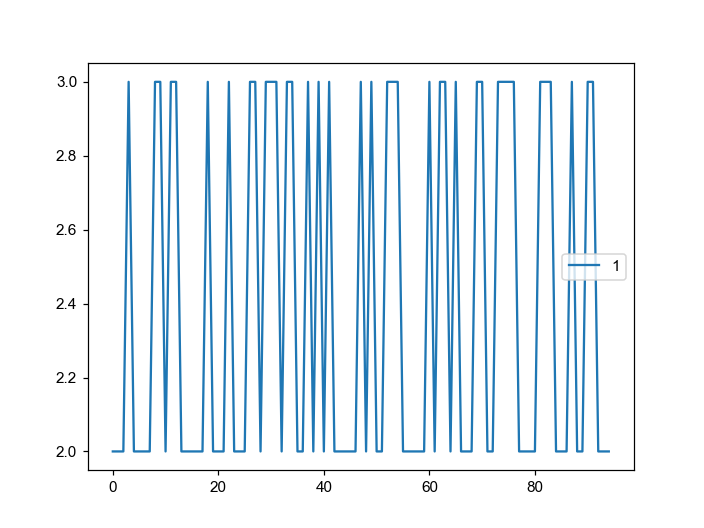

In [21]:
fig, ax = plt.subplots()
for _chr, _chr_bit_usage in chr_bit_usage_dict.items():
    ax.plot(_chr_bit_usage, label=_chr, )
    break
ax.legend()

In [22]:
def calculate_closest_overlap(code_list, code, _localtion):
    """Calculate the closest neighbor of certain code at certain location"""
    if _localtion > len(code_list) or _localtion < 0:
        raise ValueError(f"invalid _location")
    _code_list = np.array(code_list)
    if len(_code_list) == 0:
        return np.inf
    else:
        _min_dists = []
        for _c in code:
            if not (_code_list==_c).any():
                _min_dists.append(np.inf)
            else:
                _match_loc,_  = np.where(_code_list == _c)
                _dists = np.abs(_match_loc - _localtion)
                _dists[_match_loc >= _localtion] += 1
                _min_dists.append(np.min(_dists))

    return np.float(np.min(_min_dists))

In [23]:
sorted_chr_bits = {}
sorted_chr_dists = {}
for _chr, _chr_bits in chr_bit_usage_dict.items():
    print(_chr)
    _chr_bits = np.array(chr_2_region_bits[_chr])
    code_degrees = np.array([np.sum(chr_bit_usage_dict[_chr][_b])-3 for _b in _chr_bits])

    final_codes = []
    final_dist = 0

    # it seems the random doesnt help
    for _iter in range(1000):
        ordered_codes = []
        #ordered_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==np.min(code_degrees))]]
        #random.shuffle(ordered_codes)
        #for _degree in np.unique(code_degrees)[1:]:
        for _degree in np.unique(code_degrees):
            _cand_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==_degree)]]
            #print(_cand_codes, len(_cand_codes))
            #random.shuffle(_cand_codes)
            #print(_cand_codes, len(_cand_codes))
            for _code in _cand_codes:
                _dists = []
                for _i in range(0, len(ordered_codes)+1):
                    _dists.append(calculate_closest_overlap(ordered_codes, _code, _i))
                ordered_codes.insert(np.argmax(_dists), _code)
                #print(_dists, np.argmax(_dists))

        # check order
        final_dists = []
        for _i, _code in enumerate(ordered_codes):
            _other_codes = [_c for _j, _c in enumerate(ordered_codes) if _i != _j]
            final_dists.append(calculate_closest_overlap(_other_codes, _code, _i))
        if min(final_dists) > final_dist:
            final_dist = min(final_dists)
            final_codes = [np.array(_c) for _c in ordered_codes]
            print(min(final_dists), 'change')
    
    sorted_chr_bits[_chr] = np.array(final_codes)
    sorted_chr_dists[_chr] = np.array(final_dists)

1
10.0 change
2
12.0 change
10
11.0 change
4
7.0 change
3
12.0 change
11
13.0 change
5
10.0 change
6
6.0 change
9
7.0 change
8
9.0 change
14
8.0 change
13
9.0 change
7
9.0 change
16
14.0 change
12
13.0 change
15
13.0 change
19
14.0 change
17
22.0 change
18
24.0 change
X
inf change


In [24]:
# load
chr_2_region_names = pickle.load(open(os.path.join(library_folder,'chr_2_region_names.pkl'), 'rb'))

In [25]:
# assemble to regionrate region_to_encoding_bits
region_2_bits = {}
for _chr in sorted_chr_bits:
    _chr_bits = sorted_chr_bits[_chr]
    _region_names = chr_2_region_names[_chr]
    print(_chr, len(_chr_bits), len(_region_names))
    region_2_bits.update({_g:_b for _g, _b in zip(_region_names, _chr_bits)})

1 76 76
2 73 73
10 64 64
4 61 61
3 59 59
11 57 57
5 56 56
6 56 56
9 54 54
8 52 52
14 51 51
13 49 49
7 45 45
16 37 37
12 35 35
15 35 35
19 35 35
17 34 34
18 32 32
X 7 7


In [26]:
pickle.dump(region_2_bits, open(os.path.join(encoding_folder, f'region_2_bits.pkl'), 'wb'))

In [27]:
region_2_bits

{1: array([ 3, 47, 76]),
 2: array([ 8, 54, 90]),
 3: array([29, 69, 87]),
 4: array([51, 65, 73]),
 5: array([35, 53, 60]),
 6: array([11, 18, 19]),
 7: array([52, 62, 89]),
 8: array([14, 30, 85]),
 9: array([15, 63, 84]),
 10: array([43, 68, 70]),
 11: array([45, 57, 81]),
 12: array([12, 79, 92]),
 13: array([42, 47, 66]),
 14: array([20, 21, 39]),
 15: array([ 9, 71, 72]),
 16: array([17, 31, 61]),
 17: array([24, 74, 94]),
 18: array([ 4, 28, 83]),
 19: array([18, 41, 60]),
 20: array([ 0, 27, 52]),
 21: array([33, 59, 93]),
 22: array([30, 75, 82]),
 23: array([10, 34, 77]),
 24: array([40, 55, 67]),
 25: array([23, 32, 56]),
 26: array([ 9, 22, 54]),
 27: array([16, 44, 88]),
 28: array([49, 63, 81]),
 29: array([37, 39, 87]),
 30: array([69, 74, 91]),
 31: array([11, 12, 26]),
 32: array([ 6, 50, 78]),
 33: array([ 1, 13, 38]),
 34: array([41, 84, 90]),
 35: array([35, 36, 66]),
 36: array([ 7, 30, 76]),
 37: array([58, 70, 75]),
 38: array([ 3, 18, 22]),
 39: array([ 0, 19, 2

In [28]:
region_2_readout_dict = {}
for _iregion, _region in enumerate(region_2_bits):
    region_2_readout_dict[_region] = []#[f"u{_iregion}"]
    region_2_readout_dict[_region].extend([f"c{_b}" for _b in region_2_bits[_region]])

# save
pickle.dump(region_2_readout_dict, open(os.path.join(library_folder, 'region_2_readout.pkl'), 'wb'))

In [29]:
region_2_readout_dict

{1: ['c3', 'c47', 'c76'],
 2: ['c8', 'c54', 'c90'],
 3: ['c29', 'c69', 'c87'],
 4: ['c51', 'c65', 'c73'],
 5: ['c35', 'c53', 'c60'],
 6: ['c11', 'c18', 'c19'],
 7: ['c52', 'c62', 'c89'],
 8: ['c14', 'c30', 'c85'],
 9: ['c15', 'c63', 'c84'],
 10: ['c43', 'c68', 'c70'],
 11: ['c45', 'c57', 'c81'],
 12: ['c12', 'c79', 'c92'],
 13: ['c42', 'c47', 'c66'],
 14: ['c20', 'c21', 'c39'],
 15: ['c9', 'c71', 'c72'],
 16: ['c17', 'c31', 'c61'],
 17: ['c24', 'c74', 'c94'],
 18: ['c4', 'c28', 'c83'],
 19: ['c18', 'c41', 'c60'],
 20: ['c0', 'c27', 'c52'],
 21: ['c33', 'c59', 'c93'],
 22: ['c30', 'c75', 'c82'],
 23: ['c10', 'c34', 'c77'],
 24: ['c40', 'c55', 'c67'],
 25: ['c23', 'c32', 'c56'],
 26: ['c9', 'c22', 'c54'],
 27: ['c16', 'c44', 'c88'],
 28: ['c49', 'c63', 'c81'],
 29: ['c37', 'c39', 'c87'],
 30: ['c69', 'c74', 'c91'],
 31: ['c11', 'c12', 'c26'],
 32: ['c6', 'c50', 'c78'],
 33: ['c1', 'c13', 'c38'],
 34: ['c41', 'c84', 'c90'],
 35: ['c35', 'c36', 'c66'],
 36: ['c7', 'c30', 'c76'],
 37: ['c58